# Importing libraries


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go


# Load data


In [2]:
kickstarter_clean_df = pd.read_csv(
    "./data/Part3.Team8.kickstarter_data_full_cleaned.csv", low_memory=False
)

# Hypothesis 5: The category of the project is related to the success of the project.


In [3]:
h5_df = kickstarter_clean_df[["category", "SuccessfulBool"]]

In [4]:
dummy_df = pd.get_dummies(h5_df["category"], drop_first=True).astype("int")

In [5]:
h5_dummy_df = pd.concat([h5_df, dummy_df], axis=1)

In [6]:
h5_dummy_df.drop(columns=["category"], inplace=True)

## xgboost for feature importance on a classification problem

In [7]:
import plotly.graph_objects as go
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(
    h5_dummy_df.drop(columns=["SuccessfulBool"]),
    h5_dummy_df["SuccessfulBool"],
)
feature_importance_df = pd.DataFrame(
    {
        "feature": h5_dummy_df.drop(columns=["SuccessfulBool"]).columns,
        "importance": xgb_model.feature_importances_,
    }
)
feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=feature_importance_df["feature"],
        y=feature_importance_df["importance"],
        marker_color="rgb(171, 226, 251)",
    )
)
fig.update_layout(
    title="Feature Importance",
    title_x=0.5,
    width=800,
    height=800,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)
fig.show()

In [8]:
h5_dummy_df.drop(
    columns=[
        col
        for col in h5_dummy_df.columns
        if col
        not in [
            "SuccessfulBool",
            "Web",
            "Software",
        ]
    ],
    inplace=True,
)

In [12]:
X = h5_dummy_df.drop(columns=["SuccessfulBool"])
y = h5_dummy_df["SuccessfulBool"]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression


dummy_logreg = LogisticRegression()

dummy_logreg.fit(X_train, y_train)

LogisticRegression()

## AUC score

In [15]:
# auc score
from sklearn.metrics import roc_auc_score

y_pred = dummy_logreg.predict(X_test)
y_pred_proba = dummy_logreg.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.6439176457995904

## Confusion matrix

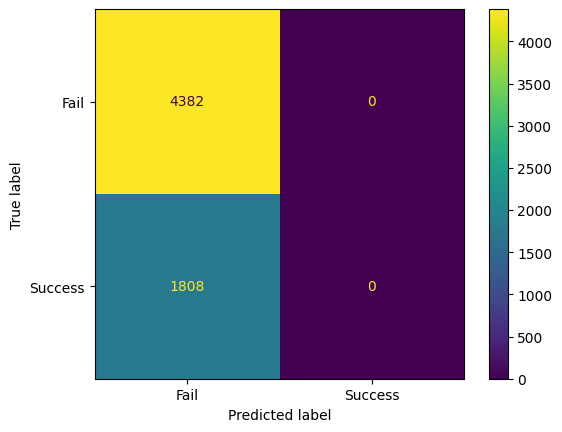

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot()

# Split into X and y


In [17]:
X = h5_df.drop(columns="SuccessfulBool")
y = h5_df["SuccessfulBool"]


## Logistic Regression


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

blurb_train, blurb_test, y_train, y_test = train_test_split(
    X["category"], y, test_size=0.3, random_state=42
)

vectorizer = CountVectorizer()

vectorizer.fit(blurb_train)

X_train = vectorizer.transform(blurb_train)

X_test = vectorizer.transform(blurb_test)

classifier = LogisticRegression()

classifier.fit(X_train, y_train)


LogisticRegression()

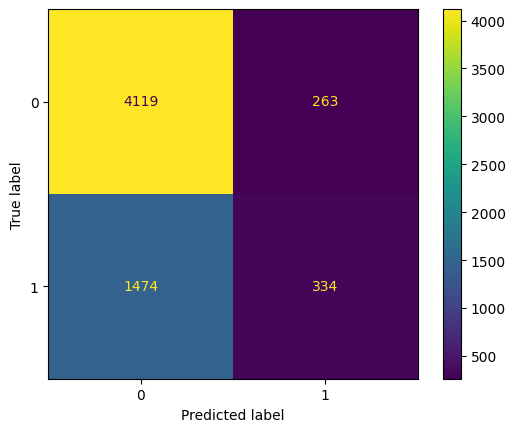

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, classifier.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

In [20]:
from sklearn.metrics import classification_report

print(
    "Classification Report train:",
    classification_report(y_train, classifier.predict(X_train)),
)
print(
    "Classification Report test:",
    classification_report(y_test, classifier.predict(X_test)),
)


Classification Report train:               precision    recall  f1-score   support

           0       0.74      0.94      0.83     10232
           1       0.55      0.18      0.27      4210

    accuracy                           0.72     14442
   macro avg       0.64      0.56      0.55     14442
weighted avg       0.68      0.72      0.66     14442

Classification Report test:               precision    recall  f1-score   support

           0       0.74      0.94      0.83      4382
           1       0.56      0.18      0.28      1808

    accuracy                           0.72      6190
   macro avg       0.65      0.56      0.55      6190
weighted avg       0.68      0.72      0.67      6190



In [21]:
# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [22]:
# Plot ROC curve
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=fpr,
        y=tpr,
        name="ROC curve (area = %0.2f)" % roc_auc,
        line=dict(color="darkorange", width=2),
        text=thresholds,
        hovertemplate="fpr: %{x:.2f}<br>tpr: %{y:.2f}<br>threshold: %{text:.2f}",
    )
)
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        line=dict(color="navy", width=2, dash="dash"),
    )
)
fig.update_layout(
    width=800,
    height=800,
    title_text="ROC curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
)
fig.show()


In [23]:
print("AUC: ", roc_auc)

AUC:  0.7166607385200116


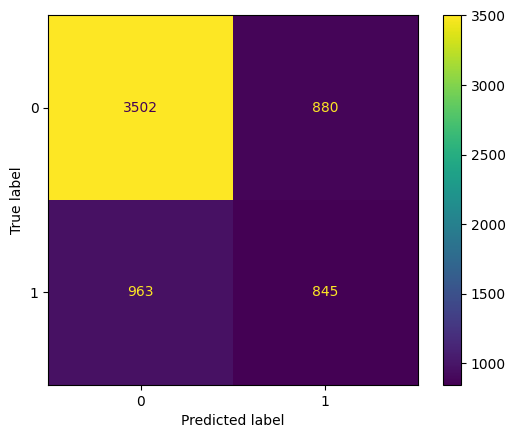

In [24]:
# threshold = 0.37
y_pred = classifier.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred > 0.37, 1, 0)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()


In [25]:
print("Classification Report threshold 0.37:", classification_report(y_test, y_pred))


Classification Report threshold 0.37:               precision    recall  f1-score   support

           0       0.78      0.80      0.79      4382
           1       0.49      0.47      0.48      1808

    accuracy                           0.70      6190
   macro avg       0.64      0.63      0.64      6190
weighted avg       0.70      0.70      0.70      6190



In [26]:
from sklearn.metrics import roc_auc_score


print("AUC after threshold 0.37: ", roc_auc_score(y_test, y_pred))

AUC after threshold 0.37:  0.6332728569812951


## Multinomial Naive Bayes


In [31]:
from sklearn.naive_bayes import MultinomialNB

blurb_train, blurb_test, y_train, y_test = train_test_split(
    X["category"], y, test_size=0.3, random_state=42
)

vectorizer = CountVectorizer()

vectorizer.fit(blurb_train)

X_train = vectorizer.transform(blurb_train)

X_test = vectorizer.transform(blurb_test)

classifier = MultinomialNB()

classifier.fit(X_train, y_train)

MultinomialNB()

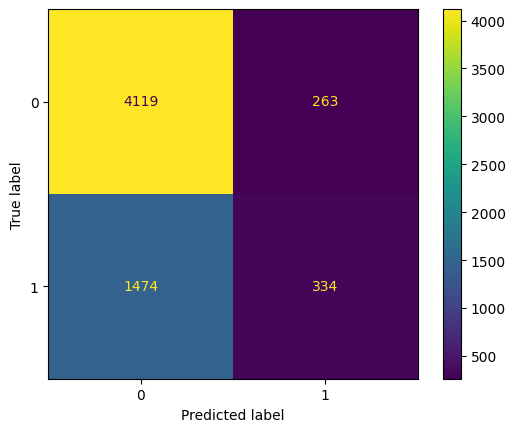

In [32]:
cm = confusion_matrix(y_test, classifier.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

In [33]:
print(
    "Classification Report train:",
    classification_report(y_train, classifier.predict(X_train)),
)
print(
    "Classification Report test:",
    classification_report(y_test, classifier.predict(X_test)),
)

Classification Report train:               precision    recall  f1-score   support

           0       0.74      0.94      0.83     10232
           1       0.55      0.18      0.27      4210

    accuracy                           0.72     14442
   macro avg       0.64      0.56      0.55     14442
weighted avg       0.68      0.72      0.66     14442

Classification Report test:               precision    recall  f1-score   support

           0       0.74      0.94      0.83      4382
           1       0.56      0.18      0.28      1808

    accuracy                           0.72      6190
   macro avg       0.65      0.56      0.55      6190
weighted avg       0.68      0.72      0.67      6190



In [34]:
print("AUC: ", roc_auc_score(y_test, classifier.predict(X_test)))

AUC:  0.5623581283852285


## Neural Network


Epoch 1/6
452/452 [==============================] - 2s 2ms/step - loss: 0.6117 - accuracy: 0.7072 - val_loss: 0.6020 - val_accuracy: 0.7079
Epoch 2/6
452/452 [==============================] - 1s 2ms/step - loss: 0.5999 - accuracy: 0.7085 - val_loss: 0.5985 - val_accuracy: 0.7079
Epoch 3/6
452/452 [==============================] - 1s 2ms/step - loss: 0.5945 - accuracy: 0.7085 - val_loss: 0.5912 - val_accuracy: 0.7079
Epoch 4/6
452/452 [==============================] - 1s 2ms/step - loss: 0.5840 - accuracy: 0.7085 - val_loss: 0.5762 - val_accuracy: 0.7079
Epoch 5/6
452/452 [==============================] - 1s 2ms/step - loss: 0.5632 - accuracy: 0.7085 - val_loss: 0.5540 - val_accuracy: 0.7079
Epoch 6/6
452/452 [==============================] - 1s 2ms/step - loss: 0.5483 - accuracy: 0.7061 - val_loss: 0.5457 - val_accuracy: 0.6971


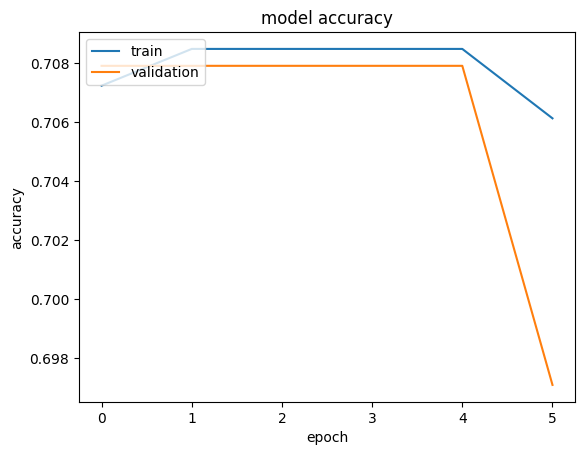

In [14]:
import tensorflow as tf


# set seed for reproducibility
tf.random.set_seed(42)

# text classification
import tensorflow as tf

blurb_train, blurb_test, y_train, y_test = train_test_split(
    X["category"], y, test_size=0.3, random_state=42
)

# Create a tokenizer to preprocess our text descriptions
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(blurb_train)

# Create training and validation sets using an 80-20 split
training_sequences = tokenizer.texts_to_sequences(blurb_train)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(
    training_sequences, maxlen=100, padding="post", truncating="post"
)

validation_sequences = tokenizer.texts_to_sequences(blurb_test)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(
    validation_sequences, maxlen=100, padding="post", truncating="post"
)

# Create the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(1000, 16, input_length=100),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model.fit(
    training_padded, y_train, epochs=6, validation_data=(validation_padded, y_test)
)

# Plot the accuracy and loss curves
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()